<a href="https://colab.research.google.com/github/oscarfedu7/Aplicaci-n-del-algoritmo-de-Entrop-a-Cruzada-para-la-optimizaci-n-de-un-portafolio/blob/Experimento-2-3-4/Experimento_completo_3_meses_y_3_meses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Obteniendo los datos

In [ ]:
import numpy as np
import pandas as pd 
!pip install yfinance
!pip install yahoofinancials
import matplotlib.pyplot as plt
import yfinance as yf

stocks=["GOOGL","TSLA","MSFT","META","CRM","AMD","NVDA","INTC","PYPL","AMZN","SAP","DIS","ORCL","TSM","SBUX","FTNT","GPRO","ASML","CSCO","V","MA"]

fecha_inicio = "2017-01-01"  #FECHA DE INICIO

df=yf.download("AAPL", start=fecha_inicio)
df["Name"]="AAPL"

for stock in stocks:
  dfp=yf.download(stock, start=fecha_inicio)
  dfp["Name"]=stock
  df=pd.concat([df, dfp], axis=0,)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15192 sha256=ea1b3e578438d43a58b02ac3cbd1ea8a63d5129889e75e4fce7783d14a501355
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

### Obteniendo los returns

In [ ]:
#OBTENIENDO LOS RETURNS

names=stocks=["AAPL","GOOGL","TSLA","MSFT","META","CRM","AMD","NVDA","INTC","PYPL","AMZN","SAP","DIS","ORCL","TSM","SBUX","FTNT","GPRO","ASML","CSCO","V","MA"]
all_dates = df.index.unique().sort_values()
start = all_dates.get_loc('2017-10-02')
end = all_dates.get_loc('2022-01-03')

dates = all_dates[start:end+1]
close_prices = pd.DataFrame(index=dates)
tmp1 = df.loc[dates]
for name in names:
  df_sym = tmp1[tmp1['Name'] == name]
  df_tmp = pd.DataFrame(data=df_sym['Close'].to_numpy(), \
                        index=df_sym.index, columns=[name])
  close_prices = close_prices.join(df_tmp) # left-join por default default
if close_prices.isna().sum().sum() > 0:
  print("Hay valores vacios")
  close_prices.fillna(method='ffill', inplace=True)
  print(close_prices.isna().sum().sum())

returns = pd.DataFrame(index=dates[1:])
for name in names:
  current_returns = np.log(close_prices[name] / close_prices[name].shift(1))
  returns[name] = current_returns.iloc[1:] * 100

In [ ]:
returns.isna().sum().sum()

0

### Obtener retornos

In [ ]:
def get_retornos(s,e):
  start = all_dates.get_loc(s)
  end = all_dates.get_loc(e)
  dates = all_dates[start:end+1]

  close_prices=pd.DataFrame(index=dates)
  tam=len(close_prices)

  for i in range(len(close_prices)-1):
    if i != 0:
      close_prices = close_prices.drop(close_prices.index[1])

  tmp1 = df.loc[dates]
  for name in names:
    df_sym = tmp1[tmp1['Name'] == name]
    df_tmp = pd.DataFrame(data=df_sym['Close'].to_numpy(), \
                        index=df_sym.index, columns=[name])
    close_prices = close_prices.join(df_tmp) # left-join by default

  retornos=pd.DataFrame(index=dates)
  for i in range((tam-1)):
    if i != 0:
      retornos = retornos.drop(retornos.index[1])

  for name in names:
    current_returns = close_prices[name].pct_change()
    retornos[name] = current_returns.iloc[1:]

  retornos = retornos.drop(retornos.index[0])
  retornos = retornos.to_numpy()
  return retornos[0]
  

### Método MPT

In [ ]:
def get_w_MPT(mean_return,cov_np):
    #Assets solos
  D = len(mean_return)
  single_asset_returns = np.zeros(D)
  single_asset_risks = np.zeros(D)
  for i in range(D):
    ret = mean_return[i]
    risk = np.sqrt(cov_np[i,i])

    single_asset_returns[i] = ret
    single_asset_risks[i] = risk

  #plt.figure(figsize=(8,6))
  #plt.scatter(single_asset_risks, single_asset_returns, c='red');
  #plt.xlabel("Riesgo")
  #plt.ylabel("Ganancia")
  #plt.title("Mean vs Desviación estandar",fontsize=15)
  #for i, label in enumerate(stocks):
  #  plt.annotate(label, (single_asset_risks[i], single_asset_returns[i]))
  #plt.show()


  #MIN AND MAX
  from scipy.optimize import linprog
  A_eq = np.ones((1, D))
  b_eq = np.ones(1)
  bounds = [(0, 1)]*D
  # minimize
  res = linprog(mean_return, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
  min_return = res.fun
  # maximize
  res = linprog(-mean_return, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
  max_return = -res.fun
  #print(min_return, max_return)


  #ENCONTRAR LA FRONTERA EFICIENTE
  N = 100
  target_returns = np.linspace(min_return, max_return, num=N)
  from scipy.optimize import minimize
  def get_portfolio_variance(weights):
    return weights.dot(cov).dot(weights)
  def target_return_constraint(weights, target):
    return weights.dot(mean_return) - target
  def portfolio_constraint(weights):
    return weights.sum() - 1


  constraints = [
      {
          'type': 'eq',
          'fun': target_return_constraint,
          'args': [target_returns[0]], # se va a estar actalizando en el ciclo
      },
      {
          'type': 'eq',
          'fun': portfolio_constraint,
      }
  ]

  optimized_risks = []
  for target in target_returns:
    # set target return constraint
    constraints[0]['args'] = [target]

    res = minimize(
        fun=get_portfolio_variance,
        x0=np.ones(D) / D, # uniform
        method='SLSQP',
        constraints=constraints,
        bounds=bounds,
    )
    optimized_risks.append(np.sqrt(res.fun))
    if res.status != 0:
      print(res)

  #plt.plot(optimized_risks, target_returns, c='black');
  #plt.xlabel('Riesgo')
  #plt.ylabel('Retorno esperado')


  # MIN VARIANZA
  res = minimize(
      fun=get_portfolio_variance,
      x0=np.ones(D) / D, # uniform
      method='SLSQP',
      constraints={
          'type': 'eq',
          'fun': portfolio_constraint,
      },
      bounds=bounds,
  )

  mv_risk = np.sqrt(res.fun)
  mv_weights = res.x
  mv_ret = mv_weights.dot(mean_return)


  #plt.plot(optimized_risks, target_returns, c='black');
  #plt.scatter([mv_risk], [mv_ret], c='red');
  #plt.xlabel('Riesgo')
  #plt.ylabel('Retorno esperado')

  w_minimo_riesgo=mv_weights



  #GET SHAPE RATIO

  # https://fred.stlouisfed.org/series/TB3MS
  #risk_free_rate = 0.04 / 22
  #risk_free_rate=0.04 / 252
  risk_free_rate=0.15 / 16
  # mean_return, cov, bounds
  def neg_sharpe_ratio(weights):
    mean = weights.dot(mean_return)
    sd = np.sqrt(weights.dot(cov).dot(weights))
    return -(mean - risk_free_rate) / sd

  res = minimize(
      fun=neg_sharpe_ratio,
      x0=np.ones(D) / D, # uniform
      method='SLSQP',
      constraints={
          'type': 'eq',
          'fun': portfolio_constraint,
      },
      bounds=bounds,
  )

  best_sr, best_w = -res.fun, res.x

  w_shape_ratio=best_w
  return [w_minimo_riesgo,w_shape_ratio] 


### Algoritmo RL 

In [ ]:
#Distribución normal truncada
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
  return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def get_elite(elite, elite_tam):
  c_elite=sorted(elite,reverse=True)
  bests=[]
  for i in range(int(elite_tam)):
    for j in range(len(elite)):
      if c_elite[i]==elite[j]:
         bests.append(j)
  return bests



#Algoritmo
def CEM(retornos): #recibe un array
  #Inicializando variables
  rendimiento= retornos #FALTA
  D=len(retornos)
  mu=np.zeros(D) 
  delta=np.ones(D)
  batch_size=50
  elite_frac=0.1 
  n_iteraciones=100

  for t in range(n_iteraciones):
    #Obtener candidatos para w
    w_total=[]
    for k in range(batch_size):
      w=np.ones(D)
      for i in range(D):
        X = get_truncated_normal(mean=mu[i], sd=delta[i], low=0, upp=1)
        w[i]=X.rvs()
      w /= np.sum(w)
      w_total.append(w)
    
    #Evaluación de candidatos w
    rend=np.ones(batch_size)
    for i in range(batch_size):
      rend[i]=rendimiento.dot(w_total[i]) #Obtener rendimiento

    #Se obtienen los indices donde están los elite_frac mejores  
    elite_tam=elite_frac*batch_size
    indices_elite=get_elite(rend, elite_tam)

    #agregamos en elite_set las elite_frac w mejores
    elite_set=[]
    for x in indices_elite:
      elite_set.append(w_total[x]) 

    #Obtenemos la nueva mu y delta
    mu=np.zeros(D)
    delta=np.ones(D)
    for i in range(D):
      data=[]
      for j in range(int(elite_tam)):
        data.append(elite_set[j][i])
      mu[i]=np.mean(data)
      delta[i]=np.std(data)

  return mu  

### Ciclo

In [ ]:
 returns[63:126]

,AAPL,GOOGL,TSLA,MSFT,META,CRM,AMD,NVDA,INTC,PYPL,...,DIS,ORCL,TSM,SBUX,FTNT,GPRO,ASML,CSCO,V,MA
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,-0.017416,1.691707,-1.028583,0.464309,1.775566,0.839297,5.061006,6.373870,-3.452737,3.865285,...,0.428415,2.289687,1.668112,1.856677,1.521619,0.669791,0.756712,0.794564,0.990623,1.249487
2018-01-04,0.463421,0.387693,-0.832453,0.876291,-0.184280,1.311525,4.817152,0.525746,-1.850868,-0.026058,...,-0.044537,0.980300,-0.528841,0.374025,-2.313923,1.062432,0.928222,-0.460585,0.371122,1.285417
2018-01-05,1.132099,1.317308,0.621042,1.232191,1.357855,1.322301,-2.000065,0.843846,0.695307,2.535031,...,-0.545010,0.600107,2.310996,1.147305,0.227009,-0.662695,1.166063,1.375460,2.366671,2.051840
2018-01-08,-0.372117,0.352438,6.075470,0.101996,0.762402,0.700595,3.311558,3.018065,0.000000,0.443749,...,-1.443813,1.046697,-0.047115,-0.504541,2.020274,-13.657554,0.523594,1.031845,0.403020,0.144520
2018-01-09,-0.011474,-0.127524,-0.811825,-0.067986,-0.218000,0.266044,-3.817891,-0.027030,-2.535226,0.176946,...,-0.072735,0.163202,-0.614510,-0.219430,-1.522641,-6.129174,-0.539999,-0.627906,-0.192909,0.144302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-28,-1.111057,-0.174942,-7.975021,-0.089457,0.530712,-0.820509,-1.918278,-1.866368,-3.155337,-1.651620,...,-0.828706,-0.885357,-1.395701,0.762837,-1.988514,-1.435916,-2.917990,-2.418900,-0.349848,-1.265802
2018-03-29,0.777843,3.130029,3.187844,2.081330,4.322644,2.984780,2.417034,4.522336,4.879023,1.073362,...,1.909799,1.697386,2.475545,-0.017276,2.456191,-1.038435,2.050492,2.909725,2.223163,2.784468
2018-04-02,-0.657783,-2.391598,-5.265286,-3.059363,-2.792233,-0.863563,-5.312796,-4.657962,-6.259476,-1.153327,...,-1.788093,-1.630714,-2.921604,-2.891637,-2.169687,-5.580842,-2.814207,-4.482279,-1.033582,-2.053364


In [ ]:
w_SR_list[0]

array([1.36935709e-15, 3.51459487e-15, 3.21936095e-15, 1.24223408e-01,
       4.89175914e-15, 9.36312302e-16, 5.83251559e-15, 3.57299126e-15,
       2.94107324e-02, 2.86526614e-15, 7.97688299e-02, 1.63557148e-15,
       1.80697317e-01, 1.94754656e-15, 2.66570517e-15, 1.27174023e-01,
       2.46558906e-01, 6.15458508e-15, 2.32065160e-15, 1.65755559e-01,
       4.64112248e-02, 1.86503917e-15])

In [ ]:
get_retornos("2018-01-03","2022-01-03")

array([ 3.22713811,  1.65668976, 17.90906258,  2.87666481,  0.83321607,
        1.42625135, 12.00779247,  4.67063566,  0.17565181,  1.53993489,
        1.83016937,  0.24790395,  0.39615244,  0.84238112,  2.08798863,
        0.98739571,  6.39773526,  0.423231  ,  3.45326101,  0.61245859,
        0.9146562 ,  1.41158493])

In [ ]:
#EMPEZAR A HACER EL CICLO
x1=0
x2=63 #3 MESES entrenamiento y 3 meses ganancia
x_inicial1=x1
x_inicial2=x2
ganancia_varianza_min=[]
ganancia_shape_ratio=[]
ganancia_CEM=[]
fechas_x2=[]
w_SR_list=[]
w_CEM_list=[]
w_VM_list=[]

while x2<=(len(returns)-1):
  mean_return = returns[x1:x2].mean()
  cov = returns[x1:x2].cov()
  cov_np = cov.to_numpy()
  

  #ALGORITMO
  #Encontrar w con MPT
  w = get_w_MPT(mean_return, cov_np)
  w_varianza_min=w[0]
  w_sharpe_ratio=w[1]

  #Encontrar w con RL
  w_CEM = CEM(get_retornos(returns[x1:x2].index[x_inicial1], returns[x1:x2].index[x_inicial2-1]))


  #Obtener la ganancia
  x1=x2
  x2=x2+x_inicial2
  retornos=get_retornos(returns[x1:x2].index[x_inicial1], returns[x1:x2].index[x_inicial2-1])
  ganancia_varianza_min.append(w_varianza_min.dot(retornos)) 
  ganancia_shape_ratio.append(w_sharpe_ratio.dot(retornos)) 
  ganancia_CEM.append(w_CEM.dot(retornos))
  w_CEM_list.append(w_CEM)
  w_SR_list.append(w_sharpe_ratio)
  w_VM_list.append(w_varianza_min)
  fechas_x2.append(returns[x1:x2].index[x_inicial2-1])



  #fig, ax = plt.subplots(figsize=(10, 5))
  #plt.plot(optimized_risks, target_returns, c='black');

  # Shape ratio encontrado por optimization
  #opt_risk = np.sqrt(best_w.dot(cov).dot(best_w))
  #opt_ret = mean_return.dot(best_w)
  #plt.scatter([opt_risk], [opt_ret], c='red');
  

### Sharpe ratio

In [ ]:
ganancia_shape_ratio

[0.06844482208383017,
 0.1636481188487556,
 0.19545911416023057,
 -0.14385158470919052,
 0.16957682603504104,
 0.040267638576412274,
 -0.0547780244283602,
 0.2205549067727246,
 -0.12449389532285622,
 1.567337862209682,
 0.1931289759732273,
 0.20395802710470964,
 0.09288128593674963,
 0.08891991692169512,
 0.04667130485365018,
 0.24460014202644678]

In [ ]:
#Retorno acumulado Sharpe ratio
inversion=100
for x in ganancia_shape_ratio:
  inversion=inversion+(inversion*x)

inversion_final=inversion

print(inversion)
print(str(inversion-100)+"%")

894.0721515177448
794.0721515177448%


In [ ]:
#Tasa de Crecimiento Anual Promedio Sharpe ratio
import statistics
a=0
inversion=100
anual=[]
for x in ganancia_shape_ratio:
  a=a+1
  if a%4==0:
    inversion=inversion+(inversion*x)
    anual.append(inversion)
    inversion=100
  else:
    inversion=inversion+(inversion*x)

anual=np.array(anual)-100
anual.mean()

86.38109820758089

In [ ]:
#tasa de crecimiento anual compuesto
CAGR=(pow((inversion_final/100),1/4)-1)*100
CAGR

72.919169859725

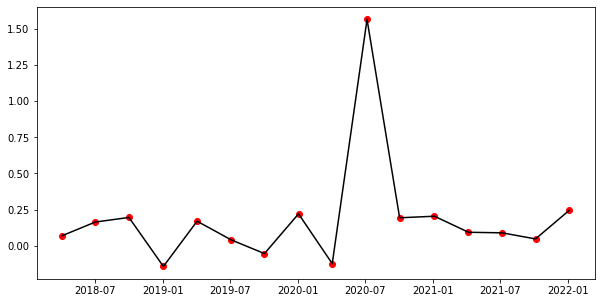

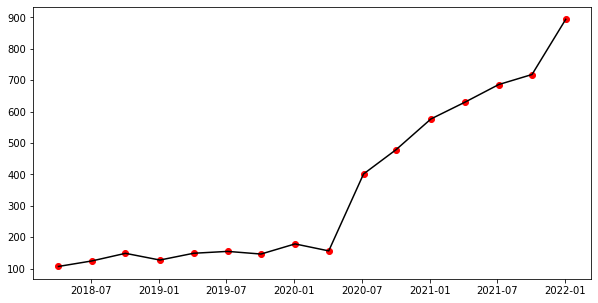

In [ ]:
#Gráfica
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(fechas_x2, ganancia_shape_ratio, c='red');
plt.plot(fechas_x2, ganancia_shape_ratio, c='black');

inversion=100
t_SR=[]
for x in ganancia_shape_ratio:
  inversion=inversion+(inversion*x)
  t_SR.append(inversion)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(fechas_x2, t_SR, c='black');
plt.scatter(fechas_x2, t_SR, c='red');

### CEM

In [ ]:
#Retorno acumulado CEM
inversion=100
for x in ganancia_CEM:
  inversion=inversion+(inversion*x)

inversion_final=inversion

print(inversion)
print(str(inversion-100)+"%")

384.885206471673
284.885206471673%


In [ ]:
#Tasa de Crecimiento Anual Promedio CEM
a=0
inversion=100
anual=[]
for x in ganancia_CEM:
  a=a+1
  if a%4==0:
    inversion=inversion+(inversion*x)
    anual.append(inversion)
    inversion=100
  else:
    inversion=inversion+(inversion*x)

anual=np.array(anual)-100
anual.mean()

42.98953281601283

In [ ]:
#tasa de crecimiento anual compuesto CEM
CAGR=(pow((inversion_final/100),1/4)-1)*100
CAGR

40.0660252962934

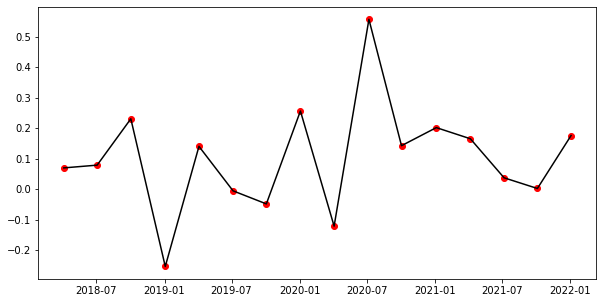

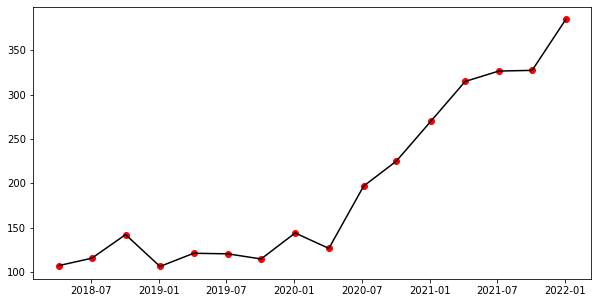

In [ ]:
#Gráfica
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(fechas_x2, ganancia_CEM, c='red');
plt.plot(fechas_x2, ganancia_CEM, c='black');

inversion=100
t=[]
for x in ganancia_CEM:
  inversion=inversion+(inversion*x)
  t.append(inversion)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(fechas_x2, t, c='black');
plt.scatter(fechas_x2, t, c='red');

### Varianza mínima

In [ ]:
#Retorno acumulado Varianza mínima
inversion=100
for x in ganancia_varianza_min:
  inversion=inversion+(inversion*x)

inversion_final=inversion

print(inversion)
print(str(inversion-100)+"%")

250.99961837263925
150.99961837263925%


In [ ]:
#Tasa de Crecimiento Anual Promedio Varianza mínima
a=0
inversion=100
anual=[]
for x in ganancia_varianza_min:
  a=a+1
  if a%4==0:
    inversion=inversion+(inversion*x)
    anual.append(inversion)
    inversion=100
  else:
    inversion=inversion+(inversion*x)

anual=np.array(anual)-100
anual.mean()

27.725203672606625

In [ ]:
#tasa de crecimiento anual compuesto varianza mínima
CAGR=(pow((inversion_final/100),1/4)-1)*100
CAGR

25.86885029147432

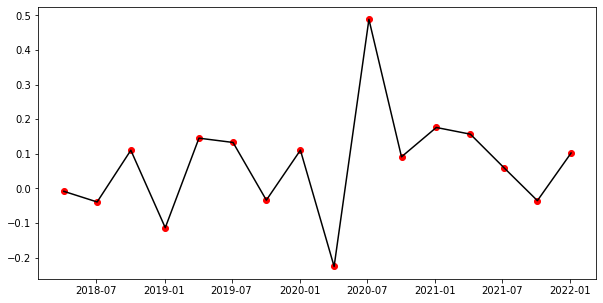

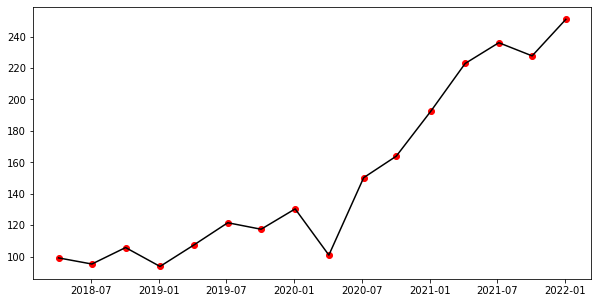

In [ ]:
#Gráfica
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(fechas_x2, ganancia_varianza_min, c='red');
plt.plot(fechas_x2, ganancia_varianza_min, c='black');

inversion=100
t=[]
for x in ganancia_varianza_min:
  inversion=inversion+(inversion*x)
  t.append(inversion)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(fechas_x2, t, c='black');
plt.scatter(fechas_x2, t, c='red');

### SP500

In [ ]:
sp500=yf.download("SPY", start=fecha_inicio)
sp500

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,203.788055,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,205.000381,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,204.837555,78379000
2017-01-06,226.529999,227.750000,225.899994,227.210007,205.570435,71559900
2017-01-09,226.910004,227.070007,226.419998,226.460007,204.891846,46939700
...,...,...,...,...,...,...
2022-09-21,386.109985,389.309998,377.380005,377.390015,377.390015,106746600
2022-09-22,376.579987,378.299988,373.440002,374.220001,374.220001,89472600
2022-09-23,370.579987,370.619995,363.290009,367.950012,367.950012,122210100


In [ ]:
all_dates.get_loc('2022-01-03')

1259

In [ ]:
sp500["Close"][251:1260][0]

268.7699890136719

In [ ]:
#Retorno acumulado Sp500
((sp500["Close"][251:1260][1008]/sp500["Close"][251:1260][0])-1)*100

77.7393351125887

In [ ]:
#Retorno promedio anual
16.497683

16.497683

In [ ]:
#tasa de crecimiento anual compuesto varianza mínima
(pow((477.71/268.77),1/4)-1)*100

15.463810357200614